**Imports**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch.optim as optim

**Loading the single image**

In [4]:
image_path = '/Users/karthik/GANS/2by2-Resized_Rotated-Topo/bio_materials/Cropped_Pattern_FeatureIdx_1000_TopoUnit_4X4_180.png'

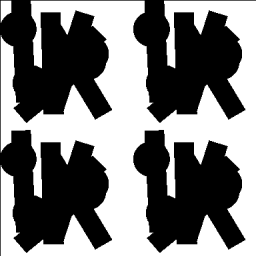

In [5]:
with Image.open(image_path) as img:
    display(img)

**Counting the image

In [6]:
path = '/Users/karthik/GANS/2by2-Resized_Rotated-Topo/'

img_names = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+ '/' +img)
        
print('Images: ',len(img_names))

Images:  8704


In [7]:
img_sizes = []

rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
            
    except:
        rejected.append(item) 

In [8]:
print(len(img_sizes))

8704


In [9]:
df = pd.DataFrame(img_sizes)

In [10]:
df.head()

,0,1
0,256,256
1,256,256
2,256,256
3,256,256
4,256,256


In [11]:
df.describe()

,0,1
count,8704.0,8704.0
mean,256.0,256.0
std,0.0,0.0
min,256.0,256.0
25%,256.0,256.0
50%,256.0,256.0
75%,256.0,256.0
max,256.0,256.0


**Parameters**

In [12]:
# Check for CUDA and use it if available, otherwise use CPU

device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration for image dimensions and channels

channels = 1  
height = 224
width = 224
material_dim = channels * height * width  # 1 * 224 * 224

# Setting hyperparameters for training

lr = 3e-4
z_dim = 112
batch_size = 64
num_epochs = 200

# Configuring the number of neurons in discriminator and generator

discriminator_neurons = 1024
generator_neurons = 256

# Preparing for generating a fixed set of images for visualization

images_generated = 16
fixed_noise = torch.randn(images_generated, z_dim).to(device)  

**Transformation**

In [13]:
transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

**Loading the Data**

- Load the File path and it will create a class called bio_materials. 

In [14]:
torch.manual_seed(42)

root = '/Users/karthik/GANS/2by2-Resized_Rotated-Topo/'
print(os.path.exists(root))

True


In [15]:
import shutil

class_dir = os.path.join(root, 'bio_materials')
os.makedirs(class_dir, exist_ok=True)

for entry in os.scandir(root):
    if entry.is_file() and entry.name.endswith('.png'):  
        shutil.move(entry.path, class_dir)


train_data = datasets.ImageFolder(root, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [16]:
for images, labels in train_loader:
    break

In [17]:
images.shape

torch.Size([64, 1, 224, 224])

**Discriminator Network**

In [18]:
# Defining the Discriminator network

class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        
        # Defining layers in the discriminator
        
        self.fc1 = nn.Linear(d_input_dim, discriminator_neurons)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
# Forward pass through the discriminator
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

**Generator Network**

In [19]:
# Defining the Generator network

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()  
        
        # Defining layers in the generator
        
        self.fc1 = nn.Linear(g_input_dim, generator_neurons)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)

# Forward pass through the generator
            
    def forward(self, x): 
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))

**Setting Dimensions for Generator & Discriminator**

In [20]:
gen = Generator(g_input_dim = z_dim, g_output_dim = material_dim).to(device)
disc = Discriminator(d_input_dim = material_dim).to(device)

**Optimizer**

In [21]:
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()

**Setting the Tensorboard**

In [22]:
from torch.utils.tensorboard import SummaryWriter 

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

- Install Tensorboard if doesn't.
- The summary writer will create the summary called logs or runs in the same directory of the notebook.
- Go to the same directory using Command Line Interface (for eg- cd [directory location fo the file].
- Run the below command and alter the command according to the created summary file.

tensorboard --logdir=runs

- A link will be shown in the CLI. Click that and tensorboard will be popped up in the browser.

In [23]:
for epoch in range(num_epochs): 
    for batch_idx, (real, _) in enumerate(train_loader):
        
        real = real.view(-1, material_dim).to(device)  # Flatten the images into vectors
        batch_size = real.shape[0]

        # Generate random noise as input for the generator
        noise = torch.randn(batch_size, z_dim).to(device)
        
        # Generate fake images with the generator
        fake = gen(noise)
        
        # Compute the discriminator losses on real images
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        # Compute the discriminator losses on fake images
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        # Combine losses for the discriminator
        lossD = (lossD_real + lossD_fake) / 2
        
        # Update discriminator
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        # Update generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()



    # After all batches are processed for the current epoch, check if it's time to print
    if (epoch + 1) % 5 == 0 or epoch == 0:
        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1,1,height,width)
            data = real.reshape(-1, 1, height, width)
            
            img_grid_real = torchvision.utils.make_grid(data[:images_generated], normalize=True)
            img_grid_fake = torchvision.utils.make_grid(fake[:images_generated], normalize=True)

            writer_real.add_image("Real", img_grid_real, global_step=step)
            writer_fake.add_image("Fake", img_grid_fake, global_step=step)

        print(f"Epoch [{epoch}/{num_epochs}] Completed - Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

    # Increment the step after each epoch
    step += 1

Epoch [0/200] Completed - Loss D: 0.4248, loss G: 6.3177
Epoch [4/200] Completed - Loss D: 1.1587, loss G: 5.5657
Epoch [9/200] Completed - Loss D: 0.2572, loss G: 2.0396
Epoch [14/200] Completed - Loss D: 0.2273, loss G: 1.2905
Epoch [19/200] Completed - Loss D: 0.2604, loss G: 2.5779
Epoch [24/200] Completed - Loss D: 0.5028, loss G: 1.3267
Epoch [29/200] Completed - Loss D: 0.1723, loss G: 2.1338
Epoch [34/200] Completed - Loss D: 0.2322, loss G: 1.8880
Epoch [39/200] Completed - Loss D: 0.4181, loss G: 1.5751
Epoch [44/200] Completed - Loss D: 0.2145, loss G: 2.4465
Epoch [49/200] Completed - Loss D: 0.3068, loss G: 2.0043
Epoch [54/200] Completed - Loss D: 0.3281, loss G: 2.2453
Epoch [59/200] Completed - Loss D: 0.5178, loss G: 1.3674
Epoch [64/200] Completed - Loss D: 0.4855, loss G: 2.3715
Epoch [69/200] Completed - Loss D: 0.3993, loss G: 3.1667
Epoch [74/200] Completed - Loss D: 0.4442, loss G: 2.9973
Epoch [79/200] Completed - Loss D: 0.5601, loss G: 1.9716
Epoch [84/200] Co

KeyboardInterrupt: 

**We got best results in 125 epochs and we decided to early stop the model**

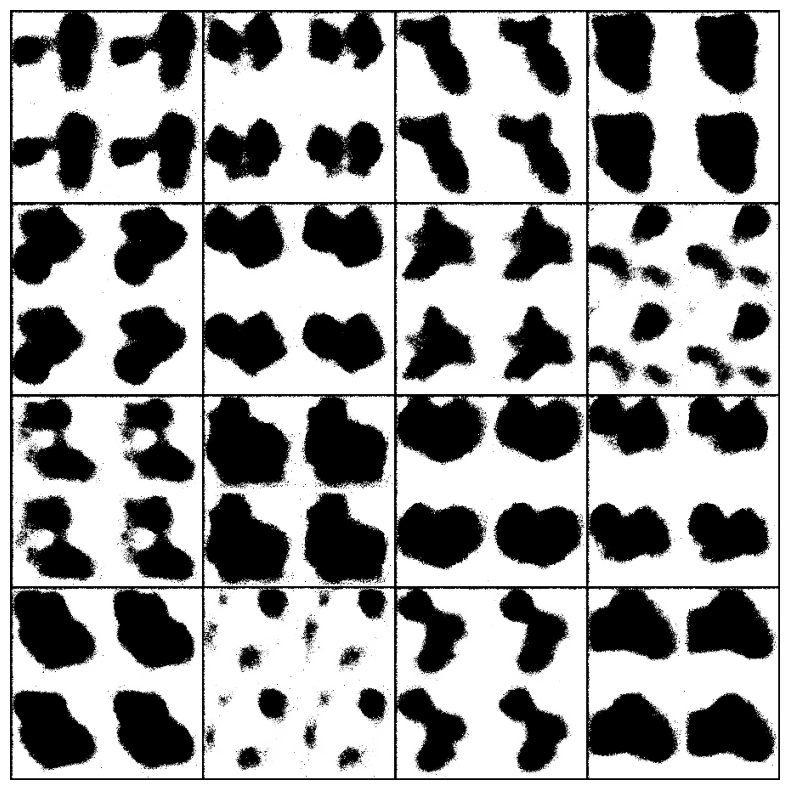

In [24]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming your generator is 'gen', and it's already trained
gen.eval()  # Set the generator to evaluation mode

# Generate fixed noise for consistent images across different runs, if not already done
# fixed_noise = torch.randn(16, z_dim, 1, 1).to(device)  # Uncomment if fixed_noise is not defined

with torch.no_grad():
    # Generate images from the fixed noise
    fake_images = gen(fixed_noise).reshape(-1, 1, height, width)  # Adjust shape if necessary
    fake_images = (fake_images + 1) / 2  # Normalize the images to [0, 1]
    fake_images = fake_images.clamp(0, 1)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(fake_images, nrow=4)  # 4 columns

    # Convert to a numpy array
    np_img_grid = img_grid.cpu().numpy().transpose(1, 2, 0)

    # Plotting
    plt.figure(figsize=(10, 10))  # Adjust the size as needed
    plt.imshow(np_img_grid)
    plt.axis('off')
    plt.show()
